## Conformally invariant dissipative relativistic fluid

Here we solve numerically the equations deduced in \ref{xxx}

### To Do:

1. Use KT also (probably has a mistake to check first)
2. Compare with the other code
3. Try some other data
4. Find some interesting (physically) data. The double shock is interesting and could be measured. 

In [1]:
import Pkg; 
#Pkg.activate(mktempdir())
#Pkg.add([
#    Pkg.PackageSpec(name="DifferentialEquations", version="6.16.0"),
#    Pkg.PackageSpec(name="Symbolics", version="0.1.22"),
#    Pkg.PackageSpec(name="ForwardDiff", version="0.10"),
#    Pkg.PackageSpec(name="Plots", version="1"),
#    Pkg.PackageSpec(name="LaTeXStrings", version="1"),
#    Pkg.PackageSpec(name="NonlinearSolve", version="0.3"),
#    Pkg.PackageSpec(name="StaticArrays", version="0.12")
    #Pkg.PackageSpec(name="OrdinaryDiffEq", version="6.17.0"),
#    ])
#Pkg.add("NonlinearSolve")
#Pkg.add("StaticArrays")
#Pkg.add("IJuliaBell")
#Pkg.add("Symbolics@0.1.22")
#Pkg.add("OrdinaryDiffEq@6.17.0")
#using NonlinearSolve 
using StaticArrays
using Symbolics
using OrdinaryDiffEq
using Plots
using FileIO
using IJuliaBell

In [2]:
#mkdir("Resultados/Soluciones")

We add the modules needed for the computation:

    choques_utils are the mp5 and kt shock capturing schemes
    
    Flux_functions_ext contain the fluxes and sources for the system
    
    inversion_ext the inversion between conservative and fluid quantities
    
The ext means that we are considering a vector of 10 variables, 5 conservative and 5 fluid variables. The fluid variables are evolved with a zero time derivative, and are updated inside the evolution equation using the inversion function.

In [45]:
include("inversion_ext.jl")

5×5 Matrix{Rational{Int64}}:
 1//1  0//1  0//1  0//1  0//1
 0//1  1//1  0//1  0//1  0//1
 0//1  0//1  3//4  0//1  1//4
 0//1  0//1  0//1  1//2  0//1
 0//1  0//1  1//4  0//1  3//4

In [46]:
U=10 # number of fields (double the number of fields, one for fluid and the other for conservative quantities)

10

In [47]:
include("choques_utils.jl") # all functions needed for evolution
include("Flux_function_ext.jl")

LoadError: LoadError: syntax: "function" at /Users/reula/Julia/Fluidos_Conformes/Flux_function_ext.jl:23 expected "end", got ")"
in expression starting at /Users/reula/Julia/Fluidos_Conformes/Flux_function_ext.jl:50

## Create initial data

In [48]:
include("initial_data.jl")

create_initial_data (generic function with 1 method)

The initial data is created by giving a string characterizing it.

According to the string, inside the function we create the initial data

Some set of parameters:

For instance: $v_0(x) = flu_0[i,2] = 0.1 + 0.1 * (x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250 $ in the interval $[0.4,0.6]$

$\mu = flu_0[i,1] = -1.$

You might give instead the conserved fields and find the fluid ones or viceversa. 

Below we look at different possibilities. 
Notice that here we also include several other evolution parameters since they can change according to the initial data chosen.


In [103]:
Euler = false
sod = false    # No implementado
speed_pulse = false # a simple speed pulse (no muy interesante pues hay pulsos en las dos direcciones)
temperature_pulse = false # a simple temperature μ pulse (no implementado)
small_pulse_to_the_right = false # low velocity perturbation pulse in just one direction
big_pulse_to_the_right = false # Choques (la velocidad no es muy alta todavía)
constant_fields = false # todo constante
big_pulse_negative_I = false
only_diss = false
# poner a continuación la que uno quiere usar con un true (así todos los demás quedan en false)

big_pulse_to_the_right = true
#big_pulse_to_the_right_E = true
#big_pulse_negative_I = true   #no parece funcionar
#small_pulse_to_the_right = true
#only_diss = true
#speed_pulse = true
#constant_fields = true

#Euler = true

true

In [104]:
if speed_pulse
    name = "speed_pulse"
    out_name = "speed_pulse" 
    L=2.4 # Length of the integration region
    M=600 # number of space-points in the discretization
    tf=4. # final time
    dx = L/M
    dt = 0.01 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations

    χ = [-1,-1,-20.] # the equation parameters 
    ξ = -100*π*[1, -15, -1] # new source parámeters     1/κ, 1/λ, 1/η 
    
elseif sod # not yet implemnted it would be important!
    name = "sod" 
    out_name = "sod" 
    L=1. # Length of the integration region
    M=400 # number of space-points in the discretization
    tf=2. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations

    χ = [-1,-1,-20.] # the equation parameters 
    ξ = -100*π*[1, -15, -1] # new source parámeters     1/κ, 1/λ, 1/η 

elseif  small_pulse_to_the_right
    name = "small_pulse_to_the_right"
    out_name = "small_right_p" 
    L=1. # Length of the integration region
    M=600 # number of space-points in the discretization
    tf=4. # 4. final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations
    χ = [-1,-1,-20.] # the equation parameters 
    ξ = -100*π*[1, -15, -1] # new source parámeters     1/κ, 1/λ, 1/η 
    
elseif  big_pulse_to_the_right
    name = "big_pulse_to_the_right"
    out_name = "big_right_long" 
    L=4. # Length of the integration region
    M=600 # number of space-points in the discretization
    tf=80. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 400  # maximum number of NR iterations
    
    χ = [-1,-1,-20.] # the equation parameters 
    ξ = -100*π*[1, -15, -1] # new source parámeters     1/κ, 1/λ, 1/η 
    
elseif  constant_fields
    name = "constant_fields"
    out_name = "constant_fields" 
    L=1. # Length of the integration region
    M=6 # number of space-points in the discretization
    tf=10. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 400  # maximum number of NR iterations
    
    χ = [-1,-1,-20.] # the equation parameters 
    ξ = -100*π*[1, -15, -1] # new source parámeters     1/κ, 1/λ, 1/η 
    
elseif  only_diss # only runs the source
    name = "only_diss"
    out_name = name
    L=4. # Length of the integration region
    M=600 # number of space-points in the discretization
    tf=1. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 400  # maximum number of NR iterations
    
    χ = [-1,-1,-20.] # the equation parameters 
    ξ = -100*π*[1, -15, -1]; # new source parámeters     1/κ, 1/λ, 1/η  
end
tf

80.0

In [105]:
par_eq = (χ, ξ) # parameters to use on the equations 
par_inv = (χ, tol, iter_max, U, M, F_alt!, Jac_alt) # parameters for the inversion
    
if Euler
    χ[2] = 0.
    χ[3] = 0.
    out_name = name*"_E"
#    par_eq = (χ, ξ) # parameters to use on the equations 
#    par_inv = (χ, tol, iter_max, U, M, F_alt!, Jac_alt) # parameters for the inversion 
end

The fields used for evolution. 

In [106]:
u_i = zeros(M*U) # flux variables for the initial data (these are used for the flux function)
du = zeros(M*U) # for the rhs
par_inidat = χ, U, M, dx, Euler, F_alt!, Jac_alt
u_i = create_initial_data(name, u_i, par_inidat)
con_0 = view(reshape(u_i,(M,U)),:,1:U÷2)
flu_0 = view(reshape(u_i,(M,U)),:,U÷2+1:U);
χ

LoadError: DomainError with -1.0748655801643265e-17:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

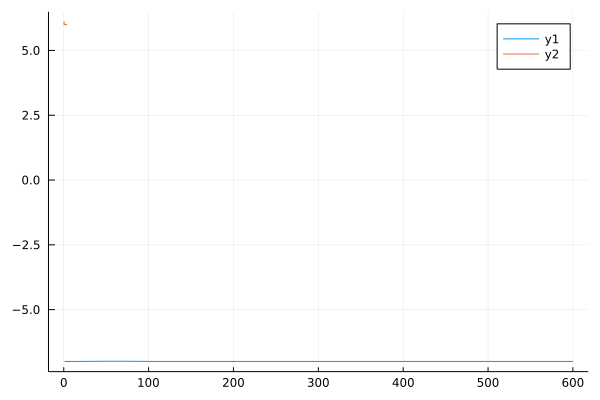

In [107]:
x = [(i-1)*dx for i in 1:M]
#plot(x,flu_0[:,1]) 
plot(flu_0[:,1] .- 6)
plot!(x,con_0[:,1])

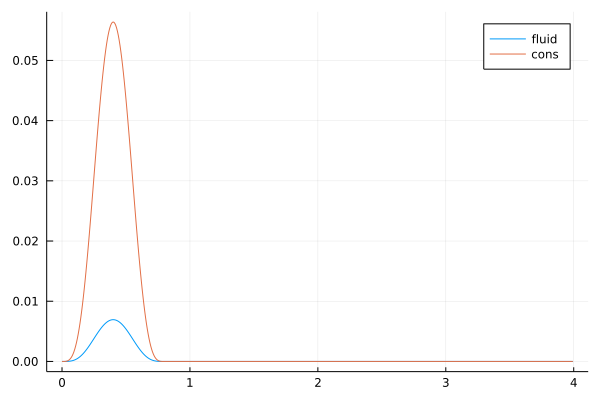

In [108]:
plot(x,flu_0[:,2], label="fluid")
plot!(x,con_0[:,2], label="cons")

## Evolution

First some memory allocations to make the functions fast:

In [109]:
#we initialize empty arrays
    F_P = Array{Float64}(undef, U);

    F_P = copy(F_P);
    F_M = copy(F_P);
    F_Pm3 = copy(F_P);
    F_Pm2 = copy(F_P);
    F_Pm1 = copy(F_P);
    F_Pp1 = copy(F_P);
    F_Pp2 = copy(F_P);
    F_Pp3 = copy(F_P);
    F_Mm3 = copy(F_P);
    F_Mm2 = copy(F_P);
    F_Mm1 = copy(F_P);
    F_Mp1 = copy(F_P);
    F_Mp2 = copy(F_P);
    F_Mp3 = copy(F_P);

    F_LP = copy(F_P);
    F_LM = copy(F_P);
    F_RM = copy(F_P);
    F_RP = copy(F_P);
    H_m = copy(F_P);
    H_p = copy(F_P);
    sourcevec = copy(F_P);
    
    par_mem = (F_Mm3, F_Mm2, F_Mm1, F_M, F_Mp1, F_Mp2, F_Mp3, F_Pm3, F_Pm2, 
    F_Pm1, F_P, F_Pp1, F_Pp2, F_Pp3, F_LP, F_LM, F_RP, F_RM, H_m, H_p, sourcevec); 

Final set of parameters to pass to the ODE integrator

In [110]:
par = (par_eq, par_inv, 1.0/dx, U, M, Flux_imp!, Speed_max, Is!, c_to_f!, par_mem);
        #par = (par_eq, par_inv, 1. /dx, U, M, Flux_imp!, Speed_max, Is_dummy!, c_to_f!, par_mem);
    #if Euler
    #    par = (par_eq, par_inv, 1. /dx, U, M, Flux_imp!, Speed_max, Is_dummy!, c_to_f!, par_mem);
    #end

In [111]:
function evolution_fast(du,u,par,t)
    # this is the function that is taken by the time-integrator
    par_eq, par_inv, h, U, M, Flux, Speed_max, Source, c_to_f, par_mem = par
    
    χ, ξ = par_eq
    
    if Euler
    c_to_f_direct!(u,(U, M))
    else
    c_to_f!(u,par_inv)
    end
    
    par_mp5 = (h, U, M, χ, par_eq, Flux, Speed_max, Source, par_mem)
    
    mp5!(du,u,par_mp5,t)
    return du[:]
end

evolution_fast (generic function with 1 method)

In [112]:
prob = ODEProblem(evolution_fast,u_i,(0.0,tf),par);
sol = solve(prob,SSPRK33(),dt=dt,saveat=0.01*tf);
    #sol = solve(prob,SSPRK33(),saveat=0.01*t);
#sol = solve(prob,SSPRK33(),dt=dt,save_everystep=false) # to get just the end values
#sol = solve(prob,RK4(),dt=dt);
@bell sleep(3)

LoadError: DomainError with -1.0748655801643265e-17:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

### Save the solution (be carefull not to overwrite old ones!) This is changed when choosing the initial data.

In [92]:
save("Resultados/Soluciones/$out_name.jld2", Dict("$out_name" => sol))
#sol = load("Resultados/Soluciones/$name.jld2","$name");

### Results analysis

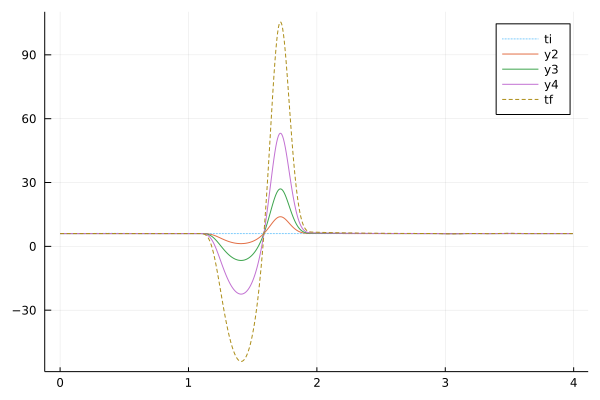

In [113]:
#sol(t) = sol_nr_p5(t) - sol_nr_n0(t)
#sol(t) = sol_n0_0(t)
field = 1
plot(x,reshape(sol(0.),(M,U))[:,field], label="ti", ls=:dot)
plot!(x,reshape(sol(tf/8),(M,U))[:,field])
plot!(x,reshape(sol(tf/4),(M,U))[:,field])
plot!(x,reshape(sol(tf/2),(M,U))[:,field])
plot!(x,reshape(sol(tf),(M,U))[:,field], label="tf", ls=:dash)

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/con_big_right_long.gif
└ @ Plots /Users/reula/.julia/packages/Plots/XuV6v/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/con_big_right_long.gif")
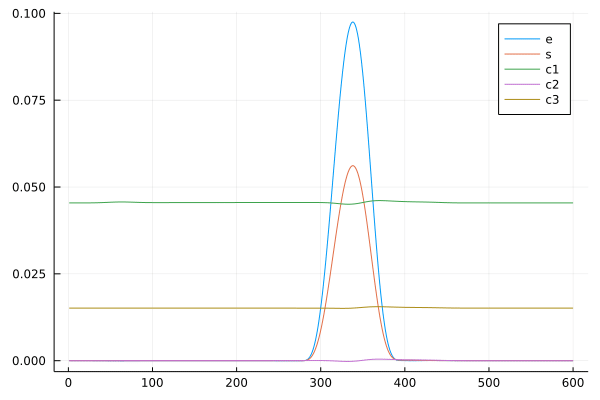

In [114]:
##### ssol(t) = sol_dir_n0(t)
#ssol(t) = sol(t)
t=tf
shift = 0# U÷2 # 0 is conserv otherwise is fluid
anim = @animate for i ∈ 1:100
    t = tf*(0.01*i)
    plot((reshape(sol(t),(M,U))[:,shift+1] .- 6.0),label="e"
        #, yaxis = ("conserv", (-1.5,1.5))
    )
    plot!((reshape(sol(t),(M,U))[:,shift+2] .- 0.),label="s")
    plot!(0.20 *reshape(sol(t),(M,U))[:,shift+3] .- 0.,label="c1")
    plot!(0.20 *reshape(sol(t),(M,U))[:,shift+4],label="c2")
    plot!(0.20 *reshape(sol(t),(M,U))[:,shift+5] .- 0.,label="c3")
end

gif(anim, "Resultados/Movies/con_$out_name.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/flu_big_right_long.gif
└ @ Plots /Users/reula/.julia/packages/Plots/XuV6v/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/flu_big_right_long.gif")
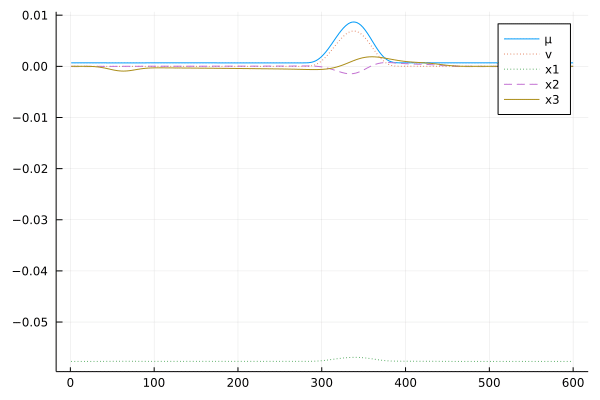

In [115]:
#ssol(t) = sol_dir_n0(t)
ssol(t) = sol(t)
shift = U÷2 # 0 is conserv otherwise is fluid
t = tf 
A1 = χ[2]       #1
A2 = -χ[3]*16/5 #-16A2 # A2 = 1.1474099846235424
A3 = χ[3]*4     #20A1 #-1.43426248077943
anim = @animate for i ∈ 1:100
    plot((reshape(ssol(t*0.01*i),(M,U))[:,shift+1] .+ 1),label="μ"
        #,yaxis = ("fluid", (-1.25,1.25))
    )
    plot!((reshape(ssol(t*0.01*i),(M,U))[:,shift+2]) ,label="v", ls=:dot)
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+3].*50 ,label="x1", ls=:dot)
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+4].*500 ,label="x2", ls=:dash)
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+5].*500 ,label="x3")
    #plot!(1.0 .*(A1 .* reshape(ssol(t*0.01*i),(M,U))[:,shift+ 1] .+ A2 .* reshape(ssol(t*0.01*i),(M,U))[:,shift+3]  .+ A3 .* reshape(ssol(t*0.01*i),(M,U))[:,shift+5] .- 1.),label="modo cero")
end

gif(anim, "Resultados/Movies/flu_$out_name.gif", fps = 10)

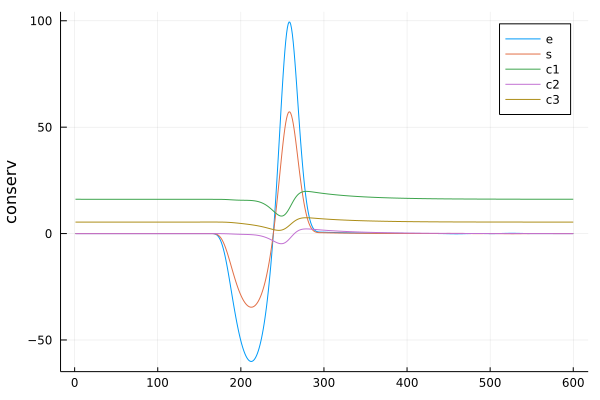

In [116]:
##### ssol(t) = sol_dir_n0(t)
ssol(t) = sol(t)
t = tf
shift = 0# U÷2 # 0 is conserv otherwise is fluid
    plot(reshape(ssol(t),(M,U))[:,shift+1] .- 6.0,label="e" 
    #,xlim = (0,60)
    , yaxis = ("conserv"
    #, (-0.25,0.2)
    )
    )
    plot!(reshape(ssol(t),(M,U))[:,shift+2] .- 0.,label="s")
    plot!(reshape(ssol(t),(M,U))[:,shift+3] .- 0.,label="c1")
    plot!(reshape(ssol(t),(M,U))[:,shift+4],label="c2")
    plot!(reshape(ssol(t),(M,U))[:,shift+5] .- 0.,label="c3")

### Zero mode: 

This part is outdated, new values have to be computed now. Not done yet.

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/zero_sourcesmall_right_p.gif
└ @ Plots /Users/reula/.julia/packages/Plots/XuV6v/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/zero_sourcesmall_right_p.gif")
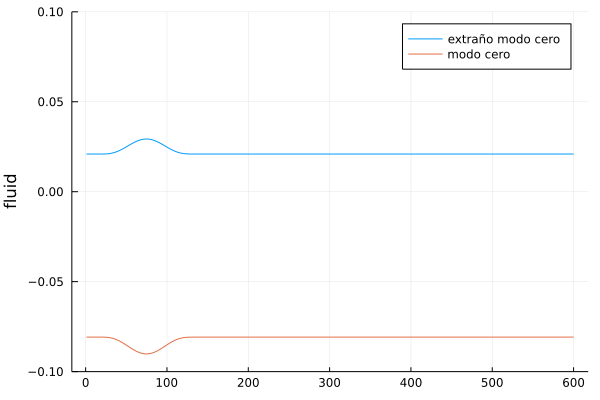

In [41]:
# This part is outdated, new values have to be computed now. Not done yet.


t = tf
A1 = 1
A2 = -16
A3 = 20
B1 = χ[2]
B2 = -χ[3]*16/5
B3 = χ[3]*4
shift = 5
anim = @animate for i ∈ 1:100
    plot(A1 .* reshape(ssol(t*0.01*i),(M,U))[:,shift+ 1] .+ A2 .* reshape(ssol(t*0.01*i),(M,U))[:,shift+3]  .+ A3 .* reshape(ssol(t*0.01*i),(M,U))[:,shift+5] .+ 1
    ,label="extraño modo cero"
    , yaxis = ("fluid", (-0.1 , 0.10))
    )
    #plot!(1.1/1.4*(B1 .* reshape(ssol(t*0.01*i),(M,U))[:,shift+ 1] .+ B2 .* reshape(ssol(t*0.01*i),(M,U))[:,shift+3]  .+ B3 .* reshape(ssol(t*0.01*i),(M,U))[:,shift+5])
    #    ,label="modo cero")
    plot!((B1 .* reshape(ssol(t*0.01*i),(M,U))[:,shift+ 1] .+ B2 .* reshape(ssol(t*0.01*i),(M,U))[:,shift+3]  .+ B3 .* reshape(ssol(t*0.01*i),(M,U))[:,shift+5] .- 1.)
        ,label="modo cero")
end

gif(anim, "Resultados/Movies/zero_source$out_name.gif", fps = 10)

### Conservation Check

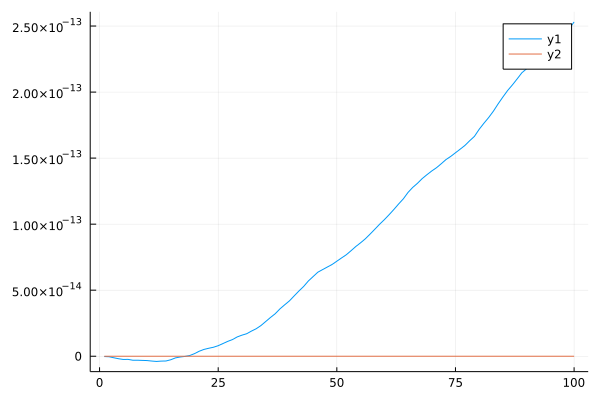

In [97]:
T00_0 = sum(reshape(sol(0),(M,U))[:,1])/M
T01_0 = sum(reshape(sol(0),(M,U))[:,2])/M
T00 = [sum(reshape(sol(tf*0.01*i) .- T00_0,(M,U))[:,1]) for i in 1:100]/M
T01 = [sum(reshape(sol(tf*0.01*i) .- T01_0,(M,U))[:,2]) for i in 1:100]/M

plot(T00)
plot!(T01)

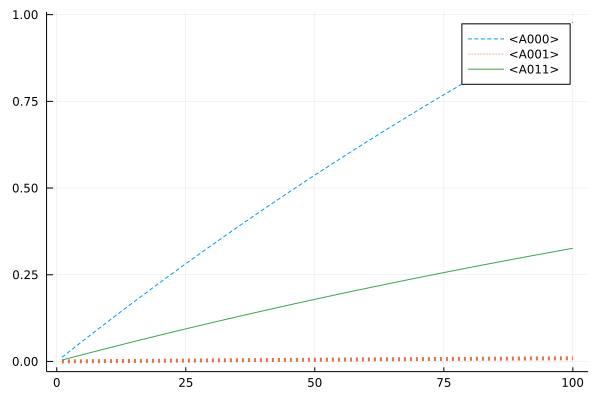

In [98]:
a000 = [sum(reshape(sol(tf*0.01*i),(M,U))[:,3]) for i in 1:100]/M
a001 = [sum(reshape(sol(tf*0.01*i),(M,U))[:,4]) for i in 1:100]/M
a011 = [sum(reshape(sol(tf*0.01*i),(M,U))[:,5]) for i in 1:100]/M


plot(a000, ls=:dash, label="<A000>")
plot!(10*a001, ls=:dot, lw=4, label="<A001>")
plot!(a011, label="<A011>")

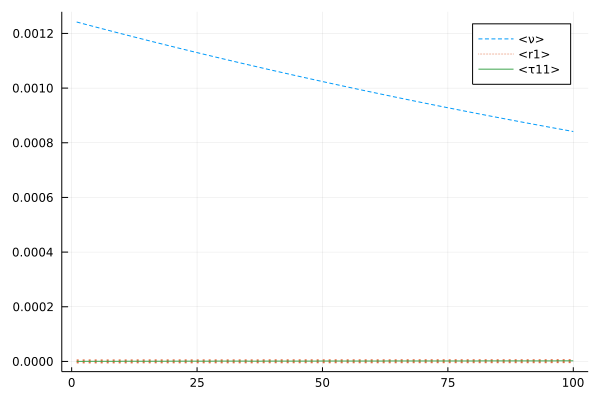

In [99]:
x1 = [sum(abs.(reshape(sol(tf*0.01*i),(M,U))[:,8])) for i in 1:100]/M
x2 = [sum(abs.(reshape(sol(tf*0.01*i),(M,U))[:,9])) for i in 1:100]/M
x3 = [sum(abs.(reshape(sol(tf*0.01*i),(M,U))[:,10])) for i in 1:100]/M
plot(x1, ls=:dash, label="<ν>")
plot!(x2, ls=:dot, lw=4, label="<r1>")
plot!(x3, label="<τ11>")

Notice that the conserved quantities initially grow a lot, the stabilize. On the other hand, the fluid fields out of equilibrium go to zero, also quite slow, but not $\tilde{\tau}^{11}$.

In [100]:
tf

4.0